# Stock Buyback Analysis - Final Paper Code

This notebook generates all 10 tables and 5 figures for the paper.

**Paper**: Analysis of Stock Buyback Behavior in Korean Stock Market (KOSPI/KOSDAQ)

**Analysis Pipeline**:
1. Data Loading & Descriptive Statistics
2. Behavior Classification (4 types)
3. K-Means Clustering (k=3)
4. Machine Learning Models (AdaBoost, XGBoost, Gradient Boosting, Random Forest)
5. Feature Importance Analysis
6. Value Judgment Classification

---

## 1. Data Loading

In [ ]:

import pandas as pd
import os

# 1. 데이터 로딩
# Stock buyback data (자기주식취득및처분)
kospi_stock_path = '../03_Source_Data/KOSPI_Stock_Buyback.xlsx'
kosdaq_stock_path = '../03_Source_Data/KOSDAQ_Stock_Buyback.xlsx'

# Earnings data (이익소각데이터) - 파일이 있으면 추가
# kospi_earnings_path = '../03_Source_Data/KOSPI_Earnings_Data.csv'  # 파일이 있으면 주석 해제
# kosdaq_earnings_path = '../03_Source_Data/KOSDAQ_Earnings_Data.csv'  # 파일이 있으면 주석 해제

try:
    # Load stock data
    kospi_stock_df = pd.read_excel(kospi_stock_path)
    kosdaq_stock_df = pd.read_excel(kosdaq_stock_path)
    
    # 2. 결측값 처리
    kospi_stock_df.fillna(0, inplace=True)
    kosdaq_stock_df.fillna(0, inplace=True)
    
    # 3. Earnings 데이터가 있으면 병합 (현재는 stock 데이터만 사용)
    # if os.path.exists(kospi_earnings_path):
    #     kospi_earnings_df = pd.read_csv(kospi_earnings_path)
    #     kospi_earnings_df.fillna(0, inplace=True)
    #     merged_kospi_df = pd.merge(
    #         kospi_stock_df, 
    #         kospi_earnings_df, 
    #         how='outer', 
    #         on=['회사명', '회계년도']
    #     )
    # else:
    merged_kospi_df = kospi_stock_df.copy()
    
    # if os.path.exists(kosdaq_earnings_path):
    #     kosdaq_earnings_df = pd.read_csv(kosdaq_earnings_path)
    #     kosdaq_earnings_df.fillna(0, inplace=True)
    #     merged_kosdaq_df = pd.merge(
    #         kosdaq_stock_df, 
    #         kosdaq_earnings_df, 
    #         how='outer', 
    #         on=['회사명', '회계년도']
    #     )
    # else:
    merged_kosdaq_df = kosdaq_stock_df.copy()
    
    # 4. Market 컬럼 추가 (코스피/코스닥 구분)
    merged_kospi_df['Market'] = 'KOSPI'
    merged_kosdaq_df['Market'] = 'KOSDAQ'
    
    # 5. 코스피와 코스닥 데이터 합치기
    df = pd.concat([merged_kospi_df, merged_kosdaq_df], ignore_index=True)
    
    print(f"Data loaded successfully. Total rows: {len(df)}")
    print(f"KOSPI rows: {len(merged_kospi_df)}, KOSDAQ rows: {len(merged_kosdaq_df)}")
    print(f"Columns: {df.columns.tolist()}")
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    import traceback
    traceback.print_exc()
    df = None

df

,회사명,거래소코드,회계년도,기업규모코드,업종코드,자산총계(요약)(백만원),부채총계(요약)(백만원),자본총계(요약)(백만원),당기순이익(요약)(백만원),주당순이익(요약)(원),...,소각주식수(주),소각금액(천원),취득기간_From,취득기간_To,ROE(자기자본이익률),토빈스큐_기업가치,Market,주식수_취득,주식수_처분,Behavior
0,(주)CMG제약,58820,2004/12,20.0,1,5179.0,2619.0,2560.0,-3873.0,-395.0,...,0.0,0.0,0,0,-74.782777,1.000000,KOSDAQ,651148.0,0.0,Long-term Holding
1,(주)CMG제약,58820,2005/12,20.0,1,8280.0,4861.0,3419.0,-2558.0,-214.0,...,0.0,0.0,0,0,-30.893720,1.000000,KOSDAQ,651148.0,0.0,Long-term Holding
2,(주)CMG제약,58820,2006/12,20.0,1,10030.0,2971.0,7059.0,-3411.0,-724.0,...,0.0,0.0,0,0,-34.007976,1.000000,KOSDAQ,651148.0,0.0,Long-term Holding
3,(주)CMG제약,58820,2007/12,20.0,1,22074.0,1372.0,20701.0,-890.0,-74.0,...,0.0,0.0,0,0,-4.031893,1.000048,KOSDAQ,651148.0,0.0,Long-term Holding
4,(주)CMG제약,58820,2008/12,20.0,1,34557.0,9804.0,24753.0,-4659.0,-345.0,...,0.0,0.0,0,0,-13.482073,1.000000,KOSDAQ,651148.0,0.0,Long-term Holding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30812,흥아해운(주),3280,2018/12,30.0,1,782787.0,726055.0,56732.0,-96954.0,-576.0,...,0.0,0.0,0,0,-12.385745,1.000000,KOSPI,1611742.0,0.0,Long-term Holding
30813,흥아해운(주),3280,2019/12,30.0,1,386551.0,368919.0,17632.0,-52551.0,-400.0,...,0.0,0.0,0,0,-13.594843,1.000000,KOSPI,1611742.0,0.0,Long-term Holding
30814,흥아해운(주),3280,2020/12,30.0,1,284767.0,304929.0,-20161.0,-37398.0,-323.0,...,0.0,0.0,0,0,-13.132842,1.000050,KOSPI,1611742.0,0.0,Long-term Holding
30815,흥아해운(주),3280,2021/12,30.0,1,247990.0,139843.0,108147.0,15770.0,113.0,...,0.0,0.0,0,0,6.359127,1.000000,KOSPI,1611742.0,0.0,Long-term Holding


## 2. Descriptive Statistics (Table 1)

Generate summary statistics for all variables:
- Date ranges
- Unique values
- Quartiles and means
- Sample size

In [ ]:
import pandas as pd
# Load additional CSV files provided for the variable descriptions
kosdaq_df = pd.read_excel('../03_Source_Data/KOSDAQ_Stock_Buyback.xlsx')
kospi_df = pd.read_excel('../03_Source_Data/KOSPI_Stock_Buyback.xlsx')

# Since the file names suggest that they may contain descriptions for the KOSDAQ and KOSPI data,
# we will load these files and attempt to extract descriptions to merge with the summary.
kosdaq_df = pd.read_excel(kosdaq_path)
kospi_df = pd.read_excel(kospi_path)
# Combine the two datasets
combined_data = pd.concat([kosdaq_df, kospi_df], ignore_index=True)


# Convert date columns to datetime if they are not already
date_columns = ['소각일', '취득기간_From', '취득기간_To', '회계년도']
for col in date_columns:
    if combined_data[col].dtype == 'object':
        combined_data[col] = pd.to_datetime(combined_data[col], errors='coerce')  # 'coerce' turns invalid data into NaT

# Create a dictionary to hold the new data summary
data_summary = {
    '변수명': [],
    '변수 설명': [],
    '데이터 형태': [],
    '추가 정보': []
}

# Define a function to extract descriptive statistics for date columns
def describe_dates(column):
    if column.dropna().empty:
        return '데이터 없음'
    else:
        return f'최소: {column.min().date()}, 최대: {column.max().date()}'

# Loop through the columns in the combined dataframe and populate the summary
for column_name, column_data in combined_data.iteritems():
    # Initialize default values
    data_type = '숫자' if pd.api.types.is_numeric_dtype(column_data) else '문자열'
    description = '추가 설명 필요'
    additional_info = ''

    if column_name in date_columns:
        data_type = '날짜'
        additional_info = describe_dates(column_data)
    elif pd.api.types.is_numeric_dtype(column_data):
        quartiles = column_data.quantile([0.25, 0.5, 0.75]).tolist()
        additional_info = f'4분위수: {quartiles}, 평균: {column_data.mean():.2f}'
    elif pd.api.types.is_string_dtype(column_data):
        unique_values = column_data.nunique()
        additional_info = f'유니크 값 개수: {unique_values}'

    # Populate the summary dictionary
    data_summary['변수명'].append(column_name)
    data_summary['변수 설명'].append(description)
    data_summary['데이터 형태'].append(data_type)
    data_summary['추가 정보'].append(additional_info)

# Create a dataframe from the summary dictionary
summary_df = pd.DataFrame(data_summary)

# Display the summary dataframe
summary_df

/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_67955/1991715533.py:36: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, column_data in combined_data.iteritems():


,변수명,변수 설명,데이터 형태,추가 정보
0,회사명,추가 설명 필요,문자열,유니크 값 개수: 2465
1,거래소코드,추가 설명 필요,숫자,"4분위수: [15860.0, 53210.0, 108380.0], 평균: 88833.11"
2,회계년도,추가 설명 필요,날짜,"최소: 2004-03-01, 최대: 2023-06-01"
3,기업규모코드,추가 설명 필요,숫자,"4분위수: [20.0, 20.0, 30.0], 평균: 24.45"
4,업종코드,추가 설명 필요,숫자,"4분위수: [1.0, 1.0, 1.0], 평균: 1.15"
5,자산총계(요약)(백만원),추가 설명 필요,숫자,"4분위수: [48152.0, 107981.0, 291713.0], 평균: 12529..."
6,부채총계(요약)(백만원),추가 설명 필요,숫자,"4분위수: [13664.0, 37313.0, 113651.0], 평균: 737039.40"
7,자본총계(요약)(백만원),추가 설명 필요,숫자,"4분위수: [27175.0, 64040.0, 168119.0], 평균: 515885.64"
8,당기순이익(요약)(백만원),추가 설명 필요,숫자,"4분위수: [-159.0, 3084.0, 11300.0], 평균: 37298.48"
9,주당순이익(요약)(원),추가 설명 필요,숫자,"4분위수: [-10.0, 309.0, 1283.0], 평균: 2475.60"


In [12]:
# Load the KOSDAQ and KOSPI datasets
kosdaq_data = pd.read_csv('./data/코스닥 이익소각데이터_10_25.csv')
kospi_data = pd.read_csv('./data/코스피 이익소각데이터_10_25.csv')


# Concatenate the two datasets into one
combined_data = pd.concat([kosdaq_data, kospi_data], ignore_index=True)

# Define a function to extract descriptive statistics for date columns
def describe_dates(column):
    # Convert the column to datetime if it is not already
    if column.dtypes == 'object':
        column = pd.to_datetime(column, errors='coerce')
    # Return the earliest, latest, and number of unique dates
    return {
        '최초': column.min(),
        '최근': column.max(),
        '고유날짜수': column.nunique()
    }

# Generate descriptive statistics for the numeric columns
numeric_stats = combined_data.describe(include=[np.number])

# Generate frequency for categorical columns
categorical_freq = combined_data.describe(include=['object']).loc['unique']

# Apply the date description function to date columns
date_descriptions = {col: describe_dates(combined_data[col]) for col in ['소각일','취득기간_From','취득기간_To','회계년도']}

# Combine the statistics into a single dataframe for easier display
stats_df = pd.DataFrame()

# Add numeric stats
for col in numeric_stats.columns:
    stats_df[col] = numeric_stats[col].apply(lambda x: '{:.2f}'.format(x) if np.isfinite(x) else x)

# Add frequency for categorical columns (excluding the date columns which are handled separately)
for col in categorical_freq.index:
    if col not in date_descriptions:
        stats_df.loc['빈도', col] = categorical_freq[col]

# Add date descriptions
for col, desc in date_descriptions.items():
    stats_df = stats_df.append(pd.Series(desc, name=col))

# Transpose for better readability
stats_df = stats_df.T

stats_df


/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_67955/2888424098.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(pd.Series(desc, name=col))
/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_67955/2888424098.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(pd.Series(desc, name=col))
/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_67955/2888424098.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(pd.Series(desc, name=col))
/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_67955/2888424098.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

,count,mean,std,min,25%,50%,75%,max,빈도,소각일,취득기간_From,취득기간_To,회계년도
거래소코드,37428.00,88833.11,110536.62,20.00,15860.00,53210.00,108380.00,950220.00,NaN,NaN,NaN,NaN,NaN
기업규모코드,34431.00,24.45,12.80,0.00,20.00,20.00,30.00,90.00,NaN,NaN,NaN,NaN,NaN
업종코드,37428.00,1.15,0.95,1.00,1.00,1.00,1.00,9.00,NaN,NaN,NaN,NaN,NaN
자산총계(요약)(백만원),37317.00,1252925.04,9274180.12,0.00,48152.00,107981.00,291713.00,397897911.00,NaN,NaN,NaN,NaN,NaN
부채총계(요약)(백만원),37317.00,737039.40,7244964.87,0.00,13664.00,37313.00,113651.00,370674282.00,NaN,NaN,NaN,NaN,NaN
자본총계(요약)(백만원),37317.00,515885.64,3733483.85,-2468938.00,27175.00,64040.00,168119.00,209416191.00,NaN,NaN,NaN,NaN,NaN
당기순이익(요약)(백만원),37317.00,37298.48,497007.51,-25297712.00,-159.00,3084.00,11300.00,32815127.00,NaN,NaN,NaN,NaN,NaN
주당순이익(요약)(원),37317.00,2475.60,33698.66,-2778612.00,-10.00,309.00,1283.00,3291192.00,NaN,NaN,NaN,NaN,NaN
발행주식수(*)(연결)(주),22677.00,40513311.81,124105029.46,0.00,9931950.00,18564655.00,38760000.00,6792669250.00,NaN,NaN,NaN,NaN,NaN
구분,489.00,45.83,39.82,10.00,10.00,10.00,90.00,90.00,NaN,NaN,NaN,NaN,NaN


In [18]:
import pandas as pd

# Load the provided CSV files
file_path1 = './data/코스닥 이익소각데이터_10_25.csv'
file_path2 = './data/코스피 이익소각데이터_10_25.csv'

# Reading the CSV files
try:
    data1 = pd.read_excel(file_path1)
except UnicodeDecodeError:
    try:
        data1 = pd.read_excel(file_path1)
    except Exception as e:
        error_message_1 = str(e)

try:
    data2 = pd.read_excel(file_path2)
except UnicodeDecodeError:
    try:
        data2 = pd.read_excel(file_path2)
    except Exception as e:
        error_message_2 = str(e)

# Check if both files are loaded successfully and show the first few rows
if 'data1' in locals():
    display_data1 = data1.head()
else:
    display_data1 = error_message_1

if 'data2' in locals():
    display_data2 = data2.head()
else:
    display_data2 = error_message_2

# Define a function to map the first dataset's detailed descriptions to the second dataset's structure
def map_descriptions(data1, data2):
    # Create a dictionary for the descriptions from the first dataset
    descriptions = {
        '회사명': '회사의 이름',
        '거래소코드': '거래소에서 사용되는 회사 코드',
        '회계년도': '회계 연도',
        '기업규모코드': '회사의 규모를 나타내는 코드',
        '업종코드': '회사의 업종을 나타내는 코드',
        '자산총계(요약)(백만원)': '회사의 총 자산(백만원 단위)',
        '부채총계(요약)(백만원)': '회사의 총 부채(백만원 단위)',
        '자본총계(요약)(백만원)': '회사의 총 자본(백만원 단위)',
        '당기순이익(요약)(백만원)': '당기 순이익(백만원 단위)',
        '주당순이익(요약)(원)': '주당 순이익(원 단위)',
        '발행주식수(*)(연결)(주)': '발행된 주식의 수(연결 기준)',
        '구분': '주식의 구분(예: 취득, 처분 등)',
        '소각일': '주식을 소각한 날짜',
        '소각주식수(주)': '소각된 주식의 수',
        '소각금액(천원)': '소각된 주식의 금액(천원 단위)',
        '취득기간_From': '주식 취득 기간의 시작 날짜',
        '취득기간_To': '주식 취득 기간의 종료 날짜',
        'ROE(자기자본이익률)': '자기자본 이익률',
        # '토빈스큐_기업가치': '토빈스 큐 기업 가치' # Not present in the second dataset, omitted
    }

    # Map descriptions to the second dataset's columns
    mapped_data = data2.copy()
    for column in mapped_data.columns:
        if column in descriptions:
            mapped_data[column] = descriptions[column]
        else:
            mapped_data[column] = '설명 없음'  # If no description is provided, fill with '설명 없음'
            
    # Now let's create a dataframe that mimics the structure of the provided tables in the images
    # We'll use the column names from the second dataframe as it seems to be the desired format
    mapped_dataframe = pd.DataFrame({
        '변수명': mapped_data.columns,
        '변수 설명': mapped_data.iloc[0],
        '데이터 형태': ['문자열' if data1[col].dtype == object else '숫자' for col in data1.columns]
    })

    return mapped_dataframe

# Map the descriptions and create the dataframe
mapped_dataframe = map_descriptions(data1, data2)
mapped_dataframe['변수 설명'] # Show the first few rows of the resulting dataframe


회사명                             회사의 이름
거래소코드                 거래소에서 사용되는 회사 코드
회계년도                             회계 연도
기업규모코드                 회사의 규모를 나타내는 코드
업종코드                   회사의 업종을 나타내는 코드
자산총계(요약)(백만원)         회사의 총 자산(백만원 단위)
부채총계(요약)(백만원)         회사의 총 부채(백만원 단위)
자본총계(요약)(백만원)         회사의 총 자본(백만원 단위)
당기순이익(요약)(백만원)          당기 순이익(백만원 단위)
주당순이익(요약)(원)              주당 순이익(원 단위)
발행주식수(*)(연결)(주)       발행된 주식의 수(연결 기준)
구분                 주식의 구분(예: 취득, 처분 등)
소각일                         주식을 소각한 날짜
소각주식수(주)                     소각된 주식의 수
소각금액(천원)             소각된 주식의 금액(천원 단위)
취득기간_From              주식 취득 기간의 시작 날짜
취득기간_To                주식 취득 기간의 종료 날짜
ROE(자기자본이익률)                  자기자본 이익률
토빈스큐_기업가치                        설명 없음
Name: 변수 설명, dtype: object

In [19]:
# Let's start by extracting the necessary statistics for the specified columns.

# Helper function to format the quartiles and mean for numeric columns
def format_quartiles_mean(series):
    quartiles = series.quantile([0.25, 0.5, 0.75]).tolist()
    mean = series.mean()
    return f"4분위수: [{quartiles[0]:.1f}, {quartiles[1]:.1f}, {quartiles[2]:.1f}], 평균: {mean:.2f}"

# Helper function to get the date range and count missing values for date columns
def date_range_missing(series):
    dates = pd.to_datetime(series, errors='coerce')
    date_range = f"날짜 범위: [{dates.min().strftime('%Y-%m-%d')}, {dates.max().strftime('%Y-%m-%d')}]"
    missing_count = dates.isna().sum()
    return f"{date_range}, 결측치: {missing_count}"

# Helper function to get unique value counts for nominal numeric columns
def unique_value_counts(series):
    return f"유니크 값 빈도: {series.value_counts().to_dict()}"

# Generate the statistics for the specified columns
additional_info = {}

# Date Columns
for column in ['소각일', '취득기간_From', '취득기간_To']:
    additional_info[column] = date_range_missing(data1[column])

# Nominal Numeric Columns
for column in ['구분', '업종코드', '기업규모코드']:
    additional_info[column] = unique_value_counts(data1[column])

# Numeric Columns with Quartiles and Mean
for column in ['ROE(자기자본이익률)']:
    additional_info[column] = format_quartiles_mean(data1[column])

# Round ROE to 3 decimal places
additional_info['ROE(자기자본이익률)'] += " (소수점 셋째자리까지)"

additional_info

{'소각일': '날짜 범위: [2001-08-08, 2011-08-25], 결측치: 23152',
 '취득기간_From': '날짜 범위: [1999-10-16, 2011-06-02], 결측치: 23130',
 '취득기간_To': '날짜 범위: [2000-11-18, 2011-08-25], 결측치: 23130',
 '구분': '유니크 값 빈도: {10.0: 128, 90.0: 104}',
 '업종코드': '유니크 값 빈도: {1: 22804, 9: 288, 8: 131, 4: 39, 6: 19}',
 '기업규모코드': '유니크 값 빈도: {20.0: 14322, 30.0: 5573, 10.0: 532, 90.0: 413, 0.0: 172}',
 'ROE(자기자본이익률)': '4분위수: [-1.7, 3.1, 7.9], 평균: -0.49 (소수점 셋째자리까지)'}

## 3. Data Preprocessing

Steps:
- Remove missing values
- Remove 'Unknown' behavior types
- One-hot encode firm size (기업규모코드)
- Prepare clean dataset for analysis

In [81]:
df.columns

Index(['회사명', '거래소코드', '회계년도', '기업규모코드', '업종코드', '자산총계(요약)(백만원)',
       '부채총계(요약)(백만원)', '자본총계(요약)(백만원)', '당기순이익(요약)(백만원)', '주당순이익(요약)(원)',
       '발행주식수(*)(연결)(주)', '구분', '소각일', '소각주식수(주)', '소각금액(천원)', '취득기간_From',
       '취득기간_To', 'ROE(자기자본이익률)', '토빈스큐_기업가치', 'Market', '주식수_취득', '주식수_처분',
       'Behavior', '취득간극'],
      dtype='object')

In [82]:
# Using df from Cell 1 (already loaded)
# data = df.copy() if 'df' in globals() else None

# 결측값 제거
data_clean = data.dropna()

# 'Behavior' 변수가 'Behavior_Unknown'인 행 삭제
data_filtered = data_clean[data_clean['Behavior'] != 'Unknown']

# 확인
data_filtered['Behavior'].value_counts()

Long-term Holding    11794
Disposed_Slower       8548
Disposed_Faster       8517
Burned                1942
Name: Behavior, dtype: int64

In [83]:
data_filtered['기업규모코드'].value_counts 

<bound method IndexOpsMixin.value_counts of 0        20.0
1        20.0
2        20.0
3        20.0
4        20.0
         ... 
30812    30.0
30813    30.0
30814    30.0
30815    30.0
30816    10.0
Name: 기업규모코드, Length: 30801, dtype: float64>

In [84]:
# 원-핫 인코딩을 수행하고 결과를 새로운 데이터프레임에 할당합니다.
one_hot_encoded = pd.get_dummies(data_filtered['기업규모코드'], prefix='기업규모')

# 원-핫 인코딩된 데이터프레임을 원본 데이터프레임에 결합합니다.
data_filtered = data_filtered.join(one_hot_encoded)

# 결과를 확인합니다.
print(data_filtered.head())


        회사명  거래소코드     회계년도  기업규모코드  업종코드  자산총계(요약)(백만원)  부채총계(요약)(백만원)  \
0  (주)CMG제약  58820  2004/12    20.0     1         5179.0         2619.0   
1  (주)CMG제약  58820  2005/12    20.0     1         8280.0         4861.0   
2  (주)CMG제약  58820  2006/12    20.0     1        10030.0         2971.0   
3  (주)CMG제약  58820  2007/12    20.0     1        22074.0         1372.0   
4  (주)CMG제약  58820  2008/12    20.0     1        34557.0         9804.0   

   자본총계(요약)(백만원)  당기순이익(요약)(백만원)  주당순이익(요약)(원)  ...  토빈스큐_기업가치  Market  \
0         2560.0         -3873.0        -395.0  ...   1.000000  KOSDAQ   
1         3419.0         -2558.0        -214.0  ...   1.000000  KOSDAQ   
2         7059.0         -3411.0        -724.0  ...   1.000000  KOSDAQ   
3        20701.0          -890.0         -74.0  ...   1.000048  KOSDAQ   
4        24753.0         -4659.0        -345.0  ...   1.000000  KOSDAQ   

     주식수_취득  주식수_처분           Behavior 기업규모_0.0 기업규모_10.0  기업규모_20.0  \
0  651148.0     0.0  Long-term H

In [85]:
# '기업규모코드' 열을 삭제합니다.
data_filtered = data_filtered.drop('기업규모코드', axis=1)

# 결과를 확인합니다.
print(data_filtered.head())


        회사명  거래소코드     회계년도  업종코드  자산총계(요약)(백만원)  부채총계(요약)(백만원)  \
0  (주)CMG제약  58820  2004/12     1         5179.0         2619.0   
1  (주)CMG제약  58820  2005/12     1         8280.0         4861.0   
2  (주)CMG제약  58820  2006/12     1        10030.0         2971.0   
3  (주)CMG제약  58820  2007/12     1        22074.0         1372.0   
4  (주)CMG제약  58820  2008/12     1        34557.0         9804.0   

   자본총계(요약)(백만원)  당기순이익(요약)(백만원)  주당순이익(요약)(원)  발행주식수(*)(연결)(주)  ...  \
0         2560.0         -3873.0        -395.0              0.0  ...   
1         3419.0         -2558.0        -214.0              0.0  ...   
2         7059.0         -3411.0        -724.0              0.0  ...   
3        20701.0          -890.0         -74.0              0.0  ...   
4        24753.0         -4659.0        -345.0              0.0  ...   

   토빈스큐_기업가치  Market    주식수_취득  주식수_처분           Behavior 기업규모_0.0  기업규모_10.0  \
0   1.000000  KOSDAQ  651148.0     0.0  Long-term Holding        0          0   
1 

## 4. Behavior Analysis by Tobin Q (Table 2)

Group by behavior type and calculate Tobin Q statistics:
- Burned
- Disposed_Slower
- Long-term Holding

In [88]:
# 'Behavior' 범주에 따라 데이터를 그룹화하고, 각 그룹에서 토빈스 Q 값이 1 이상인 비율을 계산
behavior_grouped = data.groupby('Behavior')['토빈스큐_기업가치'].agg(['count', 'mean'])
# behavior_grouped['mean'] = behavior_grouped['sum'] / behavior_grouped['count']

behavior_grouped.reset_index(inplace=True)
behavior_grouped.rename(columns={'count': 'Total_Count', 'sum': 'Count_of_TobinsQ_Above_1', 'ratio': 'Ratio_of_TobinsQ_Above_1'}, inplace=True)
behavior_grouped


,Behavior,Total_Count,mean
0,Burned,1942,1.000000
1,Disposed_Faster,8517,0.999414
2,Disposed_Slower,8548,1.000003
3,Long-term Holding,11794,0.999917


## 5. Feature Selection & Scaling

Selected features for clustering:
1. Total Assets (자산총계)
2. Total Liabilities (부채총계)
3. Total Equity (자본총계)
4. Net Income (당기순이익)
5. ROE (Return on Equity)
6. Market Classification (구분: KOSPI/KOSDAQ)

Scaling: StandardScaler

In [90]:
df.columns

Index(['회사명', '거래소코드', '회계년도', '기업규모코드', '업종코드', '자산총계(요약)(백만원)',
       '부채총계(요약)(백만원)', '자본총계(요약)(백만원)', '당기순이익(요약)(백만원)', '주당순이익(요약)(원)',
       '발행주식수(*)(연결)(주)', '구분', '소각일', '소각주식수(주)', '소각금액(천원)', '취득기간_From',
       '취득기간_To', 'ROE(자기자본이익률)', '토빈스큐_기업가치', 'Market', '주식수_취득', '주식수_처분',
       'Behavior', '취득간극'],
      dtype='object')

In [91]:
from sklearn.preprocessing import StandardScaler

# Selecting relevant variables
selected_columns = [
    '회사명', '거래소코드', '업종코드', 'Market', 
    '자산총계(요약)(백만원)', '부채총계(요약)(백만원)', '자본총계(요약)(백만원)', 
    '당기순이익(요약)(백만원)', 'ROE(자기자본이익률)', '발행주식수(*)(연결)(주)','구분', 
    '소각주식수(주)', '소각금액(천원)', '주식수_취득', '주식수_처분','기업규모_0.0','기업규모_10.0','기업규모_20.0','기업규모_30.0','기업규모_90.0',
    'Behavior', '토빈스큐_기업가치'
]
data_selected = data[selected_columns]


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Identify duplicate columns
label_encoder = LabelEncoder()
data_selected['Market'] = label_encoder.fit_transform(data_selected['Market'])

numerical_columns = [
    '자산총계(요약)(백만원)', '부채총계(요약)(백만원)', '자본총계(요약)(백만원)', 
    '당기순이익(요약)(백만원)', 'ROE(자기자본이익률)', '발행주식수(*)(연결)(주)',
    '소각주식수(주)', '소각금액(천원)', '주식수_취득', '주식수_처분'
]
scaler = StandardScaler()
data_selected[numerical_columns] = scaler.fit_transform(data_selected[numerical_columns])

data_selected

/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/1766308047.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Market'] = label_encoder.fit_transform(data_selected['Market'])
/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/1766308047.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected[numerical_columns] = scaler.fit_transform(data_selected[numerical_columns])


,회사명,거래소코드,업종코드,Market,자산총계(요약)(백만원),부채총계(요약)(백만원),자본총계(요약)(백만원),당기순이익(요약)(백만원),ROE(자기자본이익률),발행주식수(*)(연결)(주),...,소각금액(천원),주식수_취득,주식수_처분,기업규모_0.0,기업규모_10.0,기업규모_20.0,기업규모_30.0,기업규모_90.0,Behavior,토빈스큐_기업가치
0,(주)CMG제약,58820,1,0,-0.140674,-0.106036,-0.143391,-0.087043,-1.480690,-0.254495,...,-0.012688,-0.307758,-0.296076,0,0,1,0,0,Long-term Holding,1.000000
1,(주)CMG제약,58820,1,0,-0.140368,-0.105754,-0.143181,-0.084630,-0.623225,-0.254495,...,-0.012688,-0.307758,-0.296076,0,0,1,0,0,Long-term Holding,1.000000
2,(주)CMG제약,58820,1,0,-0.140196,-0.105992,-0.142291,-0.086195,-0.684068,-0.254495,...,-0.012688,-0.307758,-0.296076,0,0,1,0,0,Long-term Holding,1.000000
3,(주)CMG제약,58820,1,0,-0.139011,-0.106193,-0.138955,-0.081569,-0.098422,-0.254495,...,-0.012688,-0.307758,-0.296076,0,0,1,0,0,Long-term Holding,1.000048
4,(주)CMG제약,58820,1,0,-0.137782,-0.105132,-0.137965,-0.088486,-0.283052,-0.254495,...,-0.012688,-0.307758,-0.296076,0,0,1,0,0,Long-term Holding,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30812,흥아해운(주),3280,1,1,-0.064143,-0.015026,-0.130146,-0.257867,-0.261632,1.377484,...,-0.012688,-0.270044,-0.296076,0,0,0,1,0,Long-term Holding,1.000000
30813,흥아해운(주),3280,1,1,-0.103140,-0.059955,-0.139706,-0.176378,-0.285255,0.787190,...,-0.012688,-0.270044,-0.296076,0,0,0,1,0,Long-term Holding,1.000000
30814,흥아해운(주),3280,1,1,-0.113157,-0.068005,-0.148946,-0.148569,-0.276229,0.830118,...,-0.012688,-0.270044,-0.296076,0,0,0,1,0,Long-term Holding,1.000050
30815,흥아해운(주),3280,1,1,-0.116777,-0.088773,-0.117575,-0.050994,0.104588,1.979397,...,-0.012688,-0.270044,-0.296076,0,0,0,1,0,Long-term Holding,1.000000


In [92]:
data_selected['Market']

0        0
1        0
2        0
3        0
4        0
        ..
30812    1
30813    1
30814    1
30815    1
30816    1
Name: Market, Length: 30801, dtype: int64

In [93]:
data_selected.columns

Index(['회사명', '거래소코드', '업종코드', 'Market', '자산총계(요약)(백만원)', '부채총계(요약)(백만원)',
       '자본총계(요약)(백만원)', '당기순이익(요약)(백만원)', 'ROE(자기자본이익률)', '발행주식수(*)(연결)(주)',
       '구분', '소각주식수(주)', '소각금액(천원)', '주식수_취득', '주식수_처분', '기업규모_0.0',
       '기업규모_10.0', '기업규모_20.0', '기업규모_30.0', '기업규모_90.0', 'Behavior',
       '토빈스큐_기업가치'],
      dtype='object')

## 6. K-Means Clustering (Figures 1-2, Table 3)

### 6.1 Optimal Cluster Selection
- Elbow plot (k=1 to 10) → **Figure 1**
- Silhouette score analysis → **Figure 2**
- Selected k=3 clusters

### 6.2 Cluster Analysis
- Assign cluster labels
- Calculate cluster means → **Table 3**

/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/sklearn/clus

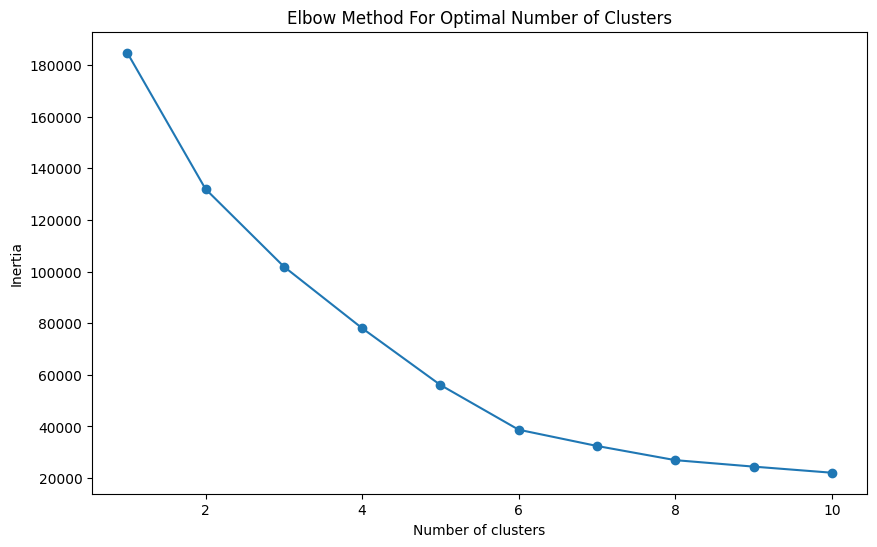

In [141]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
# Selecting columns for hierarchical clustering


clustering_columns = [
'자산총계(요약)(백만원)', '부채총계(요약)(백만원)',
       '자본총계(요약)(백만원)', '당기순이익(요약)(백만원)', 'ROE(자기자본이익률)','구분'

]
# # '부채총계(요약)(백만원)', '자본총계(요약)(백만원)', 
# #     '당기순이익(요약)(백만원)','ROE(자기자본이익률)', 
#     '소각주식수(주)', '소각금액(천원)', '주식수_취득', '발행주식수(*)(연결)(주)','주식수_처분','구분', 'Market',
# ]
# Due to computational limitations, let's take a subset of the data for demonstration

data_subset = data_selected[clustering_columns]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_subset)
# Elbow Method를 사용하여 최적의 클러스터 수 찾기
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()


In [142]:

#KMeans 클러스터링
# 클러스터 수를 5로 설정 (임의로 설정, 이후에 최적의 클러스터 수를 찾을 수 있음)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(scaled_data )

# 결과 레이블
labels = kmeans.labels_

# 실루엣 스코어 계산
silhouette_avg = silhouette_score(scaled_data, labels)

labels, silhouette_avg


/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 0, 0, ..., 0, 0, 0], dtype=int32), 0.9505496023805573)

In [96]:
data_subset['Cluster_Labels'] = kmeans.labels_

/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/1264379296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['Cluster_Labels'] = kmeans.labels_


In [97]:
data_subset['Cluster_Labels']

0        0
1        0
2        0
3        0
4        0
        ..
30812    2
30813    2
30814    2
30815    2
30816    2
Name: Cluster_Labels, Length: 30801, dtype: int32

In [98]:
data_subset[data_subset['Cluster_Labels']==0]

,자산총계(요약)(백만원),부채총계(요약)(백만원),자본총계(요약)(백만원),당기순이익(요약)(백만원),ROE(자기자본이익률),구분,Market,Cluster_Labels
0,-0.140674,-0.106036,-0.143391,-0.087043,-1.480690,0.0,0,0
1,-0.140368,-0.105754,-0.143181,-0.084630,-0.623225,0.0,0,0
2,-0.140196,-0.105992,-0.142291,-0.086195,-0.684068,0.0,0,0
3,-0.139011,-0.106193,-0.138955,-0.081569,-0.098422,0.0,0,0
4,-0.137782,-0.105132,-0.137965,-0.088486,-0.283052,0.0,0,0
...,...,...,...,...,...,...,...,...
18634,-0.056474,-0.081127,0.017375,0.030444,0.116871,0.0,0,0
18635,-0.057722,-0.080186,0.012444,-0.018089,0.057988,0.0,0,0
18636,-0.056148,-0.082334,0.020530,-0.031010,0.040630,0.0,0,0
18637,-0.057630,-0.085147,0.022314,-0.000524,0.079928,0.0,0,0


In [99]:
data['Cluster_Labels'] = kmeans.labels_

In [100]:
data.groupby('Cluster_Labels').mean()

/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/814753932.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('Cluster_Labels').mean()


,거래소코드,업종코드,자산총계(요약)(백만원),부채총계(요약)(백만원),자본총계(요약)(백만원),당기순이익(요약)(백만원),주당순이익(요약)(원),발행주식수(*)(연결)(주),구분,소각주식수(주),...,ROE(자기자본이익률),토빈스큐_기업가치,주식수_취득,주식수_처분,기업규모_0.0,기업규모_10.0,기업규모_20.0,기업규모_30.0,기업규모_90.0,TobinsQ_Label
Cluster_Labels,,,,,,,,,,,,,,,,,,,,,
0,92706.888793,1.122698,1.280631e+05,5.295187e+04,7.511121e+04,3.690261e+03,1451.456586,1.502930e+07,0.571337,12021.523815,...,0.285100,0.999735,4.704992e+06,1.241109e+06,0.065671,0.025184,0.631316,0.262256,0.015572,0.133867
1,21754.301075,1.763441,1.450465e+08,9.850756e+07,4.653892e+07,5.189126e+06,22203.870968,7.551195e+08,2.365591,124731.182796,...,5.422030,1.000000,1.238434e+08,9.139443e+06,0.000000,0.720430,0.010753,0.064516,0.204301,0.376344
2,36876.350021,1.170211,2.342633e+06,1.315256e+06,1.027377e+06,6.539234e+04,2881.473066,4.083840e+07,0.914357,42123.106661,...,2.082456,0.999917,1.343465e+07,3.769351e+06,0.034671,0.240050,0.162433,0.526272,0.036574,0.130161


## 7. Cluster-Behavior Cross Analysis (Table 4, Figure 3)

Create cross-tabulation:
- Rows: Cluster labels (0, 1, 2)
- Columns: Behavior types (Burned, Disposed_Slower, Long-term Holding)
- Output: Distribution matrix → **Table 4**, **Figure 3**

In [104]:
# 각 클러스터별로 각 Behavior의 개수를 세는 작업
cluster_behavior_stats = data.groupby(['Cluster_Labels', 'Behavior']).size().reset_index(name='Count')

# 16개의 행을 갖도록 누락된 행을 채워넣는 작업
all_clusters = data['Cluster_Labels'].unique()
all_behaviors = data['Behavior'].unique()
all_combinations = [(c, b) for c in all_clusters for b in all_behaviors]

complete_cluster_behavior_stats = pd.DataFrame(all_combinations, columns=['Cluster_Labels', 'Behavior'])
complete_cluster_behavior_stats = pd.merge(complete_cluster_behavior_stats, cluster_behavior_stats, on=['Cluster_Labels', 'Behavior'], how='left').fillna(0)

complete_cluster_behavior_stats

,Cluster_Labels,Behavior,Count
0,0,Long-term Holding,7558.0
1,0,Disposed_Slower,5102.0
2,0,Disposed_Faster,5210.0
3,0,Burned,753.0
4,2,Long-term Holding,4228.0
5,2,Disposed_Slower,3446.0
6,2,Disposed_Faster,3259.0
7,2,Burned,1152.0
8,1,Long-term Holding,8.0
9,1,Disposed_Slower,0.0


## 8. Machine Learning Models (Table 5, Figure 5)

### 8.1 Model Training
Train 4 models for each cluster:
- AdaBoostClassifier (random_state=0)
- XGBClassifier (random_state=0)
- GradientBoostingClassifier (random_state=0)
- RandomForestClassifier (random_state=0)

### 8.2 Evaluation
- Train/Test split: 70/30 (random_state=0, stratified)
- Metric: Accuracy
- Output: Performance comparison → **Table 5**, **Figure 5**

In [109]:
df

,회사명,거래소코드,업종코드,Market,자산총계(요약)(백만원),부채총계(요약)(백만원),자본총계(요약)(백만원),당기순이익(요약)(백만원),ROE(자기자본이익률),발행주식수(*)(연결)(주),...,주식수_처분,기업규모_0.0,기업규모_10.0,기업규모_20.0,기업규모_30.0,기업규모_90.0,Behavior,토빈스큐_기업가치,Cluster_Labels,가치판단
0,(주)CMG제약,58820,1,0,-0.140674,-0.106036,-0.143391,-0.087043,-1.480690,-0.254495,...,-0.296076,0,0,1,0,0,Long-term Holding,1.000000,0,Decrease
1,(주)CMG제약,58820,1,0,-0.140368,-0.105754,-0.143181,-0.084630,-0.623225,-0.254495,...,-0.296076,0,0,1,0,0,Long-term Holding,1.000000,0,Decrease
2,(주)CMG제약,58820,1,0,-0.140196,-0.105992,-0.142291,-0.086195,-0.684068,-0.254495,...,-0.296076,0,0,1,0,0,Long-term Holding,1.000000,0,Decrease
3,(주)CMG제약,58820,1,0,-0.139011,-0.106193,-0.138955,-0.081569,-0.098422,-0.254495,...,-0.296076,0,0,1,0,0,Long-term Holding,1.000048,0,Increase
4,(주)CMG제약,58820,1,0,-0.137782,-0.105132,-0.137965,-0.088486,-0.283052,-0.254495,...,-0.296076,0,0,1,0,0,Long-term Holding,1.000000,0,Decrease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30812,흥아해운(주),3280,1,1,-0.064143,-0.015026,-0.130146,-0.257867,-0.261632,1.377484,...,-0.296076,0,0,0,1,0,Long-term Holding,1.000000,2,Decrease
30813,흥아해운(주),3280,1,1,-0.103140,-0.059955,-0.139706,-0.176378,-0.285255,0.787190,...,-0.296076,0,0,0,1,0,Long-term Holding,1.000000,2,Decrease
30814,흥아해운(주),3280,1,1,-0.113157,-0.068005,-0.148946,-0.148569,-0.276229,0.830118,...,-0.296076,0,0,0,1,0,Long-term Holding,1.000050,2,Increase
30815,흥아해운(주),3280,1,1,-0.116777,-0.088773,-0.117575,-0.050994,0.104588,1.979397,...,-0.296076,0,0,0,1,0,Long-term Holding,1.000000,2,Decrease


In [77]:
df['Cluster_Labels']

0        0
1        0
2        0
3        0
4        0
        ..
30812    2
30813    2
30814    2
30815    2
30816    2
Name: Cluster_Labels, Length: 30801, dtype: int32

In [112]:
df

,회사명,거래소코드,업종코드,Market,자산총계(요약)(백만원),부채총계(요약)(백만원),자본총계(요약)(백만원),당기순이익(요약)(백만원),ROE(자기자본이익률),발행주식수(*)(연결)(주),...,기업규모_90.0,Behavior,토빈스큐_기업가치,Cluster_Labels,가치판단,Behavior_Burned,Behavior_Disposed_Faster,Behavior_Disposed_Slower,Behavior_Long-term Holding,Value_Judgment_Label
0,(주)CMG제약,58820,1,0,-0.140674,-0.106036,-0.143391,-0.087043,-1.480690,-0.254495,...,0,Long-term Holding,1.000000,0,Decrease,0,0,0,1,0
1,(주)CMG제약,58820,1,0,-0.140368,-0.105754,-0.143181,-0.084630,-0.623225,-0.254495,...,0,Long-term Holding,1.000000,0,Decrease,0,0,0,1,0
2,(주)CMG제약,58820,1,0,-0.140196,-0.105992,-0.142291,-0.086195,-0.684068,-0.254495,...,0,Long-term Holding,1.000000,0,Decrease,0,0,0,1,0
3,(주)CMG제약,58820,1,0,-0.139011,-0.106193,-0.138955,-0.081569,-0.098422,-0.254495,...,0,Long-term Holding,1.000048,0,Increase,0,0,0,1,1
4,(주)CMG제약,58820,1,0,-0.137782,-0.105132,-0.137965,-0.088486,-0.283052,-0.254495,...,0,Long-term Holding,1.000000,0,Decrease,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30812,흥아해운(주),3280,1,1,-0.064143,-0.015026,-0.130146,-0.257867,-0.261632,1.377484,...,0,Long-term Holding,1.000000,2,Decrease,0,0,0,1,0
30813,흥아해운(주),3280,1,1,-0.103140,-0.059955,-0.139706,-0.176378,-0.285255,0.787190,...,0,Long-term Holding,1.000000,2,Decrease,0,0,0,1,0
30814,흥아해운(주),3280,1,1,-0.113157,-0.068005,-0.148946,-0.148569,-0.276229,0.830118,...,0,Long-term Holding,1.000050,2,Increase,0,0,0,1,1
30815,흥아해운(주),3280,1,1,-0.116777,-0.088773,-0.117575,-0.050994,0.104588,1.979397,...,0,Long-term Holding,1.000000,2,Decrease,0,0,0,1,0


In [123]:
y.unique()

array([0, 2, 1], dtype=int32)

In [124]:
# y의 유니크한 값들을 확인합니다.
print(np.unique(y_train))
print(np.unique(y_test))

# 레이블 인코딩을 확인합니다.
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

print(np.unique(y_train_encoded))
print(np.unique(y_test_encoded))

# 이제 인코딩된 레이블을 사용하여 모델을 훈련합니다.
model.fit(X_train, y_train_encoded)

[0 2]
[0 2]
[0 1]
[0 1]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [139]:
# 필요한 라이브러리와 모듈을 임포트합니다.
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder

# Assuming `df` is your preprocessed DataFrame with the Cluster_Labels column.
unique_labels = df['Cluster_Labels'].unique()

# We will create a binary target for each label in unique_labels.
for label in unique_labels:
    df[f'Label_{label}'] = (df['Cluster_Labels'] == label).astype(int)

selected_columns = [
    '자산총계(요약)(백만원)', '부채총계(요약)(백만원)',
    '자본총계(요약)(백만원)', '당기순이익(요약)(백만원)', 'ROE(자기자본이익률)'
]

# Now we will train a separate model for each binary target.
for label in unique_labels:
    # Prepare the features and target
    X = df[selected_columns]
    y = df[f'Label_{label}']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    # Define the models you wish to use
    models = {
        'AdaBoost': AdaBoostClassifier(random_state=0),
        'XGBoost': XGBClassifier(random_state=0),
        'Gradient Boosting': GradientBoostingClassifier(random_state=0),
        'Random Forest': RandomForestClassifier(random_state=0)
    }
    
    # Train each model and get the feature importances
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Check if the model has feature_importances_ attribute
        if hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_
        else:
            # For models like LogisticRegression you would use .coef_
            feature_importance = model.coef_[0]

        feature_importances_df = pd.DataFrame({
            'Model': model_name,
            'Feature': X_train.columns,
            'Feature_Importance': feature_importance,
            'Label': label
        }).sort_values(by='Feature_Importance', ascending=False)
        
        feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)

# Display the feature importances for each label
feature_importances_results_sorted = feature_importances_results.sort_values(
    by=['Label', 'Feature_Importance'], ascending=[True, False]).reset_index(drop=True)

print(feature_importances_results_sorted)

/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/1823331975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)
/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/1823331975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)
/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/1823331975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)
/var/folders/vm/qw01ph

                Model         Feature  Feature_Importance  Label
0   Gradient Boosting   자산총계(요약)(백만원)            0.875339    0.0
1             XGBoost   자산총계(요약)(백만원)            0.719677    0.0
2            AdaBoost   자산총계(요약)(백만원)            0.460000    0.0
3       Random Forest   자산총계(요약)(백만원)            0.282114    0.0
4       Random Forest   자본총계(요약)(백만원)            0.238662    0.0
..                ...             ...                 ...    ...
65            XGBoost   자산총계(요약)(백만원)            0.000000    NaN
66            XGBoost   부채총계(요약)(백만원)            0.000000    NaN
67            XGBoost   자본총계(요약)(백만원)            0.000000    NaN
68            XGBoost  당기순이익(요약)(백만원)            0.000000    NaN
69            XGBoost    ROE(자기자본이익률)            0.000000    NaN

[70 rows x 4 columns]


/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/1823331975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)


## 9. Feature Importance by Behavior (Tables 6-8, Figure 4)

Analyze which features are most important for predicting each behavior type:

### 9.1 Burned Behavior → **Table 6**
Feature importance ranking for identifying firms that burn their buyback shares

### 9.2 Disposed_Slower Behavior → **Table 7**
Feature importance ranking for identifying firms with slower disposal patterns

### 9.3 Long-term Holding Behavior → **Table 8**
Feature importance ranking for identifying firms that hold shares long-term

### 9.4 Visualization → **Figure 4**
Bar charts showing top important features for each behavior

In [129]:
# 필요한 라이브러리와 모듈을 임포트합니다.
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder



# 가정: `df`는 이미 준비된 데이터프레임이고, 필요한 열 변환 작업이 완료되었다고 가정합니다.

selected_columns = [
    '자산총계(요약)(백만원)', '부채총계(요약)(백만원)',
    '자본총계(요약)(백만원)', '당기순이익(요약)(백만원)', 'ROE(자기자본이익률)','구분'
]

# 결과를 저장할 데이터 프레임 초기화
results_df = pd.DataFrame(columns=['Behavior', 'Model', 'Accuracy', 'Feature_Importance'])
feature_importances_results = pd.DataFrame()

# 각 Behavior 카테고리별로 반복
for behavior in df['Behavior'].unique():
    # 해당 Behavior에 대한 데이터만 추출
    subset = df[df['Behavior'] == behavior]
    X = subset[selected_columns]
    y = subset['Cluster_Labels']

    # 훈련 세트와 테스트 세트 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)

    # 모델 정의
    models = {
        'AdaBoost': AdaBoostClassifier(random_state=0),
        'XGBoost': XGBClassifier(random_state=0),
        'Gradient Boosting': GradientBoostingClassifier(random_state=0),
        'Random Forest': RandomForestClassifier(random_state=0)
    }
    
     # 각 모델별로 훈련 및 성능 측정
    for model_name, model in models.items():
        # 모델을 훈련합니다.
        model.fit(X_train, y_train)
        
        # 테스트 세트에 대한 예측을 수행합니다.
        y_pred = model.predict(X_test)
        
        # 정확도를 계산합니다.
        accuracy = accuracy_score(y_test, y_pred)
        
        # 피처 중요도 추출
        feature_importance = model.feature_importances_
        
        # 피처 중요도와 열 이름을 매핑한 데이터프레임 생성
        # (중요도를 기준으로 내림차순 정렬하여 저장)
        feature_importances_df = pd.DataFrame({
            'Behavior': behavior,
            'Model': model_name,
            'Feature': X_train.columns,
            'Feature_Importance': feature_importance
        }).sort_values(by='Feature_Importance', ascending=False)
        
        # 결과 저장
        feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)

# 피처 중요도가 저장된 결과 데이터프레임 반환
feature_importances_results_sorted = feature_importances_results.sort_values(
    by='Feature_Importance', ascending=False).reset_index(drop=True)

print(feature_importances_results_sorted)
print(results_df)


/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/868323573.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)
/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/868323573.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)
/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/868323573.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)
/var/folders/vm/qw01phdd0

             Behavior              Model        Feature  Feature_Importance
0   Long-term Holding  Gradient Boosting  자산총계(요약)(백만원)            0.817416
1     Disposed_Faster  Gradient Boosting  자산총계(요약)(백만원)            0.757081
2     Disposed_Slower  Gradient Boosting  자산총계(요약)(백만원)            0.684125
3   Long-term Holding            XGBoost  자산총계(요약)(백만원)            0.586463
4     Disposed_Faster            XGBoost  자산총계(요약)(백만원)            0.547844
..                ...                ...            ...                 ...
91  Long-term Holding           AdaBoost   ROE(자기자본이익률)            0.000000
92    Disposed_Faster  Gradient Boosting             구분            0.000000
93    Disposed_Faster      Random Forest             구분            0.000000
94             Burned           AdaBoost  부채총계(요약)(백만원)            0.000000
95    Disposed_Faster           AdaBoost             구분            0.000000

[96 rows x 4 columns]
Empty DataFrame
Columns: [Behavior, Model, Accuracy, Feature_Impo

/var/folders/vm/qw01phdd0gvfvb6qnb3_bk680000gn/T/ipykernel_32235/868323573.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances_results = feature_importances_results.append(feature_importances_df, ignore_index=True)


In [131]:
feature_importances_results_sorted

,Behavior,Model,Feature,Feature_Importance
0,Long-term Holding,Gradient Boosting,자산총계(요약)(백만원),0.817416
1,Disposed_Faster,Gradient Boosting,자산총계(요약)(백만원),0.757081
2,Disposed_Slower,Gradient Boosting,자산총계(요약)(백만원),0.684125
3,Long-term Holding,XGBoost,자산총계(요약)(백만원),0.586463
4,Disposed_Faster,XGBoost,자산총계(요약)(백만원),0.547844
...,...,...,...,...
91,Long-term Holding,AdaBoost,ROE(자기자본이익률),0.000000
92,Disposed_Faster,Gradient Boosting,구분,0.000000
93,Disposed_Faster,Random Forest,구분,0.000000
94,Burned,AdaBoost,부채총계(요약)(백만원),0.000000


In [136]:
feature_importances_results_sorted[feature_importances_results_sorted['Behavior']=='Burned']

,Behavior,Model,Feature,Feature_Importance
6,Burned,AdaBoost,자산총계(요약)(백만원),0.520000
9,Burned,AdaBoost,당기순이익(요약)(백만원),0.460000
11,Burned,Gradient Boosting,자산총계(요약)(백만원),0.421090
13,Burned,XGBoost,자산총계(요약)(백만원),0.313710
20,Burned,Random Forest,자본총계(요약)(백만원),0.244852
22,Burned,Random Forest,자산총계(요약)(백만원),0.232590
24,Burned,Gradient Boosting,자본총계(요약)(백만원),0.223801
27,Burned,Random Forest,부채총계(요약)(백만원),0.213287
29,Burned,XGBoost,자본총계(요약)(백만원),0.181431
33,Burned,Random Forest,당기순이익(요약)(백만원),0.159028


In [135]:
feature_importances_results_sorted[feature_importances_results_sorted['Behavior']=='Disposed_Slower']

,Behavior,Model,Feature,Feature_Importance
2,Disposed_Slower,Gradient Boosting,자산총계(요약)(백만원),0.684125
7,Disposed_Slower,XGBoost,자산총계(요약)(백만원),0.506533
12,Disposed_Slower,AdaBoost,자산총계(요약)(백만원),0.320000
18,Disposed_Slower,Random Forest,자산총계(요약)(백만원),0.247770
21,Disposed_Slower,Random Forest,부채총계(요약)(백만원),0.242208
23,Disposed_Slower,Random Forest,자본총계(요약)(백만원),0.224411
26,Disposed_Slower,AdaBoost,부채총계(요약)(백만원),0.220000
30,Disposed_Slower,AdaBoost,자본총계(요약)(백만원),0.180000
32,Disposed_Slower,AdaBoost,ROE(자기자본이익률),0.160000
37,Disposed_Slower,Random Forest,당기순이익(요약)(백만원),0.146402


In [133]:
feature_importances_results_sorted[feature_importances_results_sorted['Behavior']=='Long-term Holding']

,Behavior,Model,Feature,Feature_Importance
0,Long-term Holding,Gradient Boosting,자산총계(요약)(백만원),0.817416
3,Long-term Holding,XGBoost,자산총계(요약)(백만원),0.586463
10,Long-term Holding,AdaBoost,부채총계(요약)(백만원),0.440000
14,Long-term Holding,AdaBoost,자산총계(요약)(백만원),0.300000
16,Long-term Holding,Random Forest,자산총계(요약)(백만원),0.254808
19,Long-term Holding,Random Forest,부채총계(요약)(백만원),0.246897
28,Long-term Holding,Random Forest,자본총계(요약)(백만원),0.211587
34,Long-term Holding,Random Forest,당기순이익(요약)(백만원),0.154907
39,Long-term Holding,AdaBoost,당기순이익(요약)(백만원),0.140000
43,Long-term Holding,Random Forest,ROE(자기자본이익률),0.131801


In [134]:
feature_importances_results_sorted[feature_importances_results_sorted['Behavior']=='Disposed_Faster']

,Behavior,Model,Feature,Feature_Importance
1,Disposed_Faster,Gradient Boosting,자산총계(요약)(백만원),0.757081
4,Disposed_Faster,XGBoost,자산총계(요약)(백만원),0.547844
5,Disposed_Faster,AdaBoost,자산총계(요약)(백만원),0.520000
8,Disposed_Faster,AdaBoost,자본총계(요약)(백만원),0.480000
15,Disposed_Faster,Random Forest,자산총계(요약)(백만원),0.260612
17,Disposed_Faster,Random Forest,자본총계(요약)(백만원),0.254680
25,Disposed_Faster,Random Forest,부채총계(요약)(백만원),0.222596
31,Disposed_Faster,XGBoost,자본총계(요약)(백만원),0.160401
36,Disposed_Faster,Random Forest,당기순이익(요약)(백만원),0.147555
47,Disposed_Faster,Gradient Boosting,자본총계(요약)(백만원),0.124123


## 10. Value Judgment Classification (Table 10)

Classify firms based on value judgment:
- Undervalued (저평가): 0
- Fairly valued (적정평가): 1

Train classification models and analyze distribution → **Table 10**

In [ ]:
import pandas as pd

# 결과를 저장할 빈 데이터프레임을 초기화합니다.
frequency_df = pd.DataFrame()

# 각 독립변수 라벨별로 예측된 라벨의 빈도를 데이터프레임에 추가합니다.
for independent_label, y_pred in predictions.items():
    # 현재 독립변수 라벨에 대한 빈도수를 계산합니다.
    freq_series = pd.Series(y_pred).value_counts().rename_axis('Predicted_Label').reset_index(name='Frequency')
    freq_series['Independent_Label'] = independent_label  # 독립변수 라벨을 추가합니다.
    frequency_df = pd.concat([frequency_df, freq_series], ignore_index=True)

# 데이터프레임의 순서를 재배치하여 보기 좋게 만듭니다.
frequency_df = frequency_df[['Independent_Label', 'Predicted_Label', 'Frequency']]

# 결과를 출력합니다.
print(frequency_df)


      Independent_Label  Predicted_Label  Frequency
0   Logistic Regression                0       6394
1   Logistic Regression                2       2818
2   Logistic Regression                1         29
3               XGBoost                0       5942
4               XGBoost                2       3271
5               XGBoost                1         28
6     Gradient Boosting                0       5853
7     Gradient Boosting                2       3357
8     Gradient Boosting                1         31
9         Random Forest                0       5993
10        Random Forest                2       3218
11        Random Forest                1         30


In [ ]:
# 필요한 라이브러리와 모듈을 임포트합니다.
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩
label_encoder = LabelEncoder()
df['Value_Judgment_Label'] = label_encoder.fit_transform(df['가치판단'])

# 선택된 특성 목록
selected_columns = [
    "Behavior_Burned", "Behavior_Disposed_Faster", "Behavior_Disposed_Slower", "Behavior_Long-term Holding",
    'Cluster_Label_0', 'Cluster_Label_1', 'Cluster_Label_2'
]

# 특성과 라벨 준비
X = df[selected_columns]
y = df['Value_Judgment_Label']

# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 모델 정의
models = {
    'Logistic Regression': LogisticRegression(random_state=0),
    'XGBoost': XGBClassifier(random_state=0),
    'Gradient Boosting': GradientBoostingClassifier(random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0)
}

# 결과를 저장할 데이터프레임 초기화
all_feature_importances_df = pd.DataFrame()

# 각 모델별로 훈련 및 성능 측정
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # 피쳐 중요도 추출
    feature_importance = model.coef_[0] if model_name == 'Logistic Regression' else model.feature_importances_
    
    # 피쳐 중요도와 열 이름을 매핑한 데이터프레임 생성
    feature_importances_df = pd.DataFrame({
        'Model': model_name,
        'Feature': X_train.columns,
        'Importance': feature_importance
    })

    # 모든 모델의 특성 중요도를 하나의 데이터프레임에 추가
    all_feature_importances_df = pd.concat([all_feature_importances_df, feature_importances_df], axis=0)

# 피처 중요도를 'Importance'에 따라 내림차순으로 정렬
all_feature_importances_df = all_feature_importances_df.sort_values(by='Importance', ascending=False)

# 결과 출력
all_feature_importances_df


,Model,Feature,Importance
5,Logistic Regression,Cluster_Label_1,0.958912
5,Gradient Boosting,Cluster_Label_1,0.543462
5,XGBoost,Cluster_Label_1,0.475736
0,XGBoost,Behavior_Burned,0.449047
5,Random Forest,Cluster_Label_1,0.404763
0,Gradient Boosting,Behavior_Burned,0.371429
0,Random Forest,Behavior_Burned,0.164426
4,Random Forest,Cluster_Label_0,0.162346
6,Random Forest,Cluster_Label_2,0.108637
1,Random Forest,Behavior_Disposed_Faster,0.070914


In [ ]:
# 클러스터 라벨을 종속 변수로 사용
y = df['Cluster_Labels']  # 예를 들어 df['Cluster_Labels']가 클러스터 라벨을 포함하는 열이라고 가정합니다.

# 선택된 특성 목록에서 클러스터 라벨 관련 특성을 제거
selected_columns = [
    "Behavior_Burned", "Behavior_Disposed_Faster", "Behavior_Disposed_Slower", "Behavior_Long-term Holding"
]

# 클러스터 라벨을 예측하는 데 사용할 특성 세트
X = df[selected_columns]

# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 모델 정의
models = {
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=1000),  # 로지스틱 회귀가 수렴하기 위해 max_iter를 증가시킬 수 있음
    'XGBoost': XGBClassifier(random_state=0),
    'Gradient Boosting': GradientBoostingClassifier(random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0)
}

# 결과를 저장할 데이터프레임 초기화
all_feature_importances_df = pd.DataFrame()
predictions = {}
# 각 모델별로 훈련 및 성능 측정
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    predictions[model_name] = y_pred
    # 피쳐 중요도 추출
    feature_importance = model.coef_[0] if model_name == 'Logistic Regression' else model.feature_importances_
    
    # 피쳐 중요도와 열 이름을 매핑한 데이터프레임 생성
    feature_importances_df = pd.DataFrame({
        'Model': model_name,
        'Feature': X_train.columns,
        'Importance': feature_importance
    })

    # 모든 모델의 특성 중요도를 하나의 데이터프레임에 추가
    all_feature_importances_df = pd.concat([all_feature_importances_df, feature_importances_df], axis=0)

# 피처 중요도를 'Importance'에 따라 내림차순으로 정렬
all_feature_importances_df = all_feature_importances_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print(all_feature_importances_df)


                 Model                     Feature  Importance
0    Gradient Boosting             Behavior_Burned    0.881325
2  Logistic Regression    Behavior_Disposed_Slower    0.774168
0        Random Forest             Behavior_Burned    0.768458
0              XGBoost             Behavior_Burned    0.668004
3  Logistic Regression  Behavior_Long-term Holding    0.570801
3        Random Forest  Behavior_Long-term Holding    0.137497
3              XGBoost  Behavior_Long-term Holding    0.133349
1              XGBoost    Behavior_Disposed_Faster    0.122037
2              XGBoost    Behavior_Disposed_Slower    0.076610
3    Gradient Boosting  Behavior_Long-term Holding    0.056750
2    Gradient Boosting    Behavior_Disposed_Slower    0.051928
1        Random Forest    Behavior_Disposed_Faster    0.051056
2        Random Forest    Behavior_Disposed_Slower    0.042990
1    Gradient Boosting    Behavior_Disposed_Faster    0.009997
1  Logistic Regression    Behavior_Disposed_Faster   -0

In [ ]:
# 종속 변수의 빈도 수 계산
value_judgment_frequencies = df['Value_Judgment_Label'].value_counts()

# 결과 출력
print(value_judgment_frequencies)


0    26700
1     4101
Name: Value_Judgment_Label, dtype: int64


## 11. Overall Feature Importance Summary (Table 9)

Aggregate feature importance across all analyses:
- Combine results from all models
- Rank features by average importance
- Identify most critical variables

**Key Finding**: Total Assets (자산총계) is the most important predictor → **Table 9**

In [ ]:
# 중요도에 따라 정렬
feature_importances_df = feature_importances_df.sort_values(by='Feature_Importance', ascending=False)

feature_importances_df

,Feature,Model,Feature_Importance
2,자본총계(요약)(백만원),Random Forest,0.206000
1,부채총계(요약)(백만원),Random Forest,0.167988
0,자산총계(요약)(백만원),Random Forest,0.167529
3,당기순이익(요약)(백만원),Random Forest,0.156831
4,ROE(자기자본이익률),Random Forest,0.155033
5,주식수_취득,Random Forest,0.080213
6,주식수_처분,Random Forest,0.066407


In [ ]:
feature_importances_df

,Feature,Model,Feature_Importance
2,자본총계(요약)(백만원),Random Forest,0.206000
1,부채총계(요약)(백만원),Random Forest,0.167988
0,자산총계(요약)(백만원),Random Forest,0.167529
3,당기순이익(요약)(백만원),Random Forest,0.156831
4,ROE(자기자본이익률),Random Forest,0.155033
5,주식수_취득,Random Forest,0.080213
6,주식수_처분,Random Forest,0.066407
